# Data Science Case Study - Necip Yildizcan

This case study is based on an IBM Sample Data Set and can be used to test modelling approaches for modelling customer churn and to support insight into the factors that management might consider in their customer retention programmes 

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

-	Customers who left within the last month – the column is called Churn
-	Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
-	Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
-	Demographic info about customers – gender, age range, and if they have partners and dependents. 


In [ ]:
# Import libaries and packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

In [36]:
# Read Dataset from csv file
df = pd.read_csv(r"../data/Churn_Modelling_Case_Study.csv")

## High level view of Dataset

In [10]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Categorical columns : Tenure, Monthly Charges and Total Charges

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


High View conclusions:

- "Total Charges" column needs to be changed 
-  Drop "customerID" column as there are no new information given by the column.

## Data Cleaning

In [37]:
df.isnull().sum() 

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [38]:
df.TotalCharges = pd.to_numeric(df.TotalCharges,errors="coerce")

In [39]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

11 missing data in total charges. Drop these rows from the dataset

In [40]:
df=df.dropna()

The "customerID" column does not provide any predictive value for churn analysis, as it is simply a unique identifier for each customer. Therefore, it is appropriate to drop this column from the dataset to streamline the analysis and modeling process.

In [ ]:
df=df.drop(['customerID'],axis=1)


Data Cleaning conclusions: 

11 rows have been dropped and the data is prepared for data exploration

## Data Exploration

This section is an exploration of the dataset to gain an understanding of the variables and their distributions. This will help identify potential features that could be important for predicting churn.

   ### Churn Baseline 

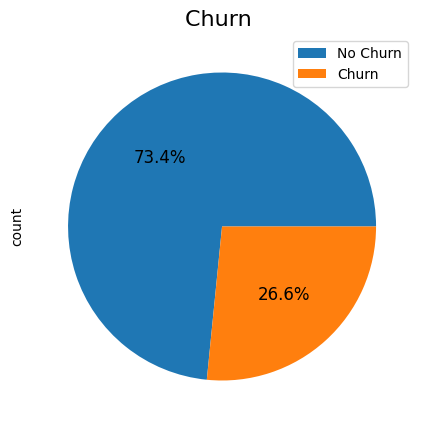

In [16]:
plt.figure(figsize=(5,5))

df['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['', ''],fontsize=12)
plt.legend(labels=['No Churn', 'Churn'])
plt.title('Churn ', fontsize=16)

plt.show()

There is a 26.6% rate of customer churn. As we move on to analyze the features, we can compare this number with the percentage of churn found for each category, providing us a better idea on the impact of a given feature in the company’s ability to retain its customers.

### Features influence to Churn

This section explores the features influence to Churn. The features are split into three groups:
   - Services that each customer signed up for
   - Customer Account Information
   - Demographic Information about Customers

To visulaise the infludence of variables against Churn, plots are used.

For categorical variables, normalized bar plots with percentages are plotted. Normalised bar plots are useful in comparing when comparing the distribution of the same categorical variable across different categories or groups

For numeric variables, histograms are plotted. Histograms are used to evaluate the influence of each independent numeric variable in the outcome.

### Services

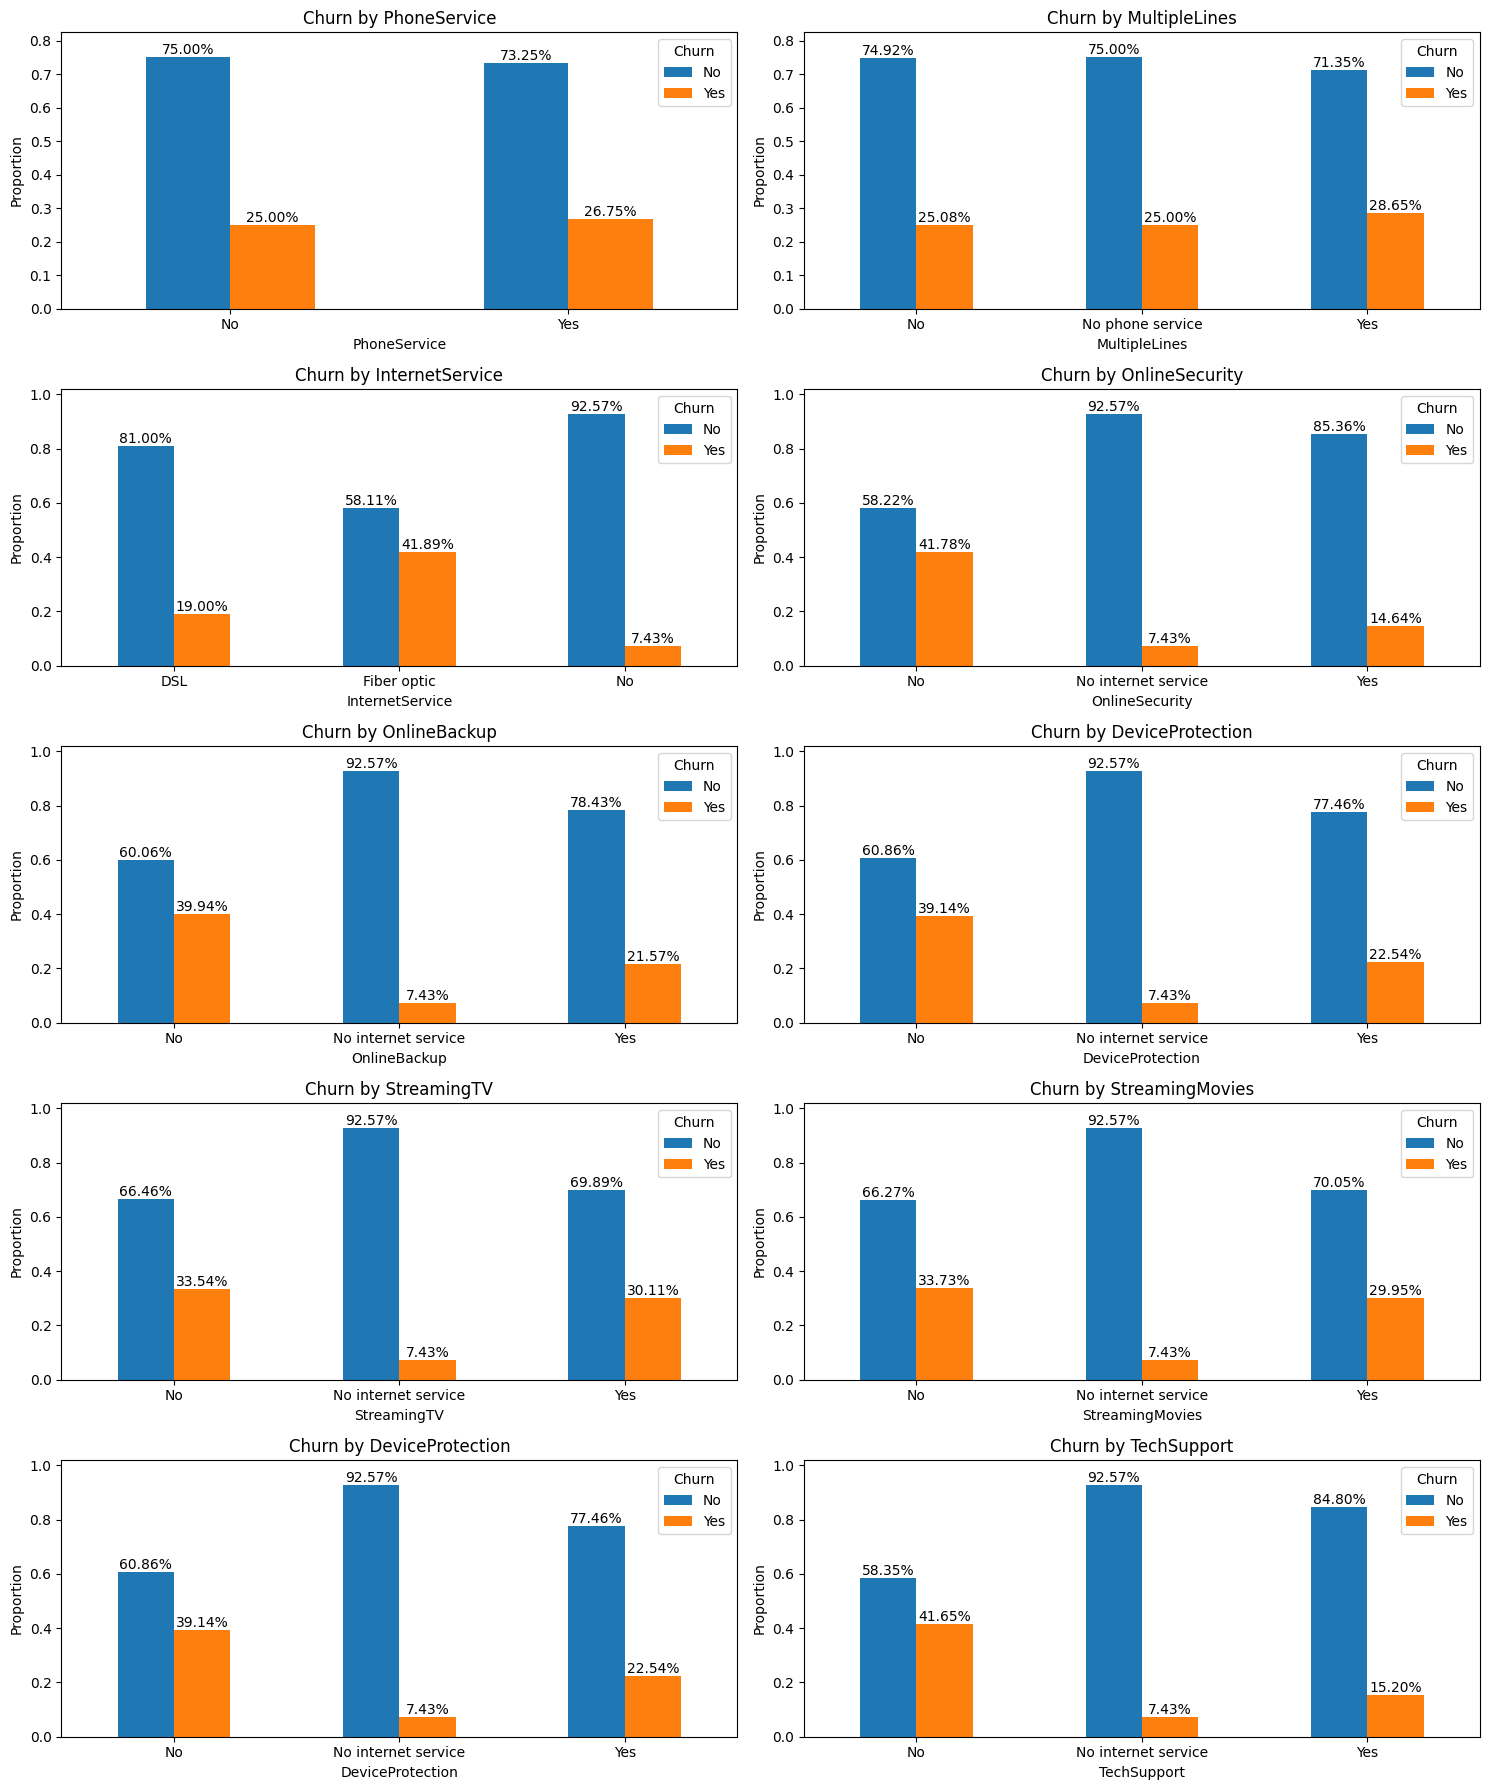

In [17]:
fig, ax = plt.subplots(5, 2, figsize=(15, 18), sharex=False, sharey=False)

# Loop over each subplot
for i, (col, subplot) in enumerate(zip(
    [
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies',
    'DeviceProtection','TechSupport'
], ax.flatten())):

    # Create the crosstab for the current subplot
    ctr = pd.crosstab(index=df[col], columns=df['Churn'])

    # Normalize the data
    ctr_norm = ctr.div(ctr.sum(axis=1), axis=0)

    # Create the stacked bar chart
    ctr_norm.plot.bar(ax=subplot, rot=0, width=0.5)

    # Add percentages for each segment of the bar chart
    for j, bar in enumerate(subplot.containers):
        total = ctr.iloc[j].sum()
        for rect in bar:
            percentage = f"{100*rect.get_height():.2f}%"
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height()
            subplot.text(x, y, percentage, ha='center', va='bottom', fontsize=10)

    # Add axis labels and title
    subplot.set_xlabel(col)
    subplot.set_ylabel('Proportion')
    subplot.set_title(f'Churn by {col}')

    # Add extra spacing between subplots
    subplot.margins(0.10)

plt.tight_layout()
plt.show()



By evaluating the services attributes, we can extract some conclusions on their predictive power for churn:

- Phone attributes such as PhoneService and MultipleLines are not expected to have significant predictive power for churn.
- Clients with online security tend to churn less than those without it.
- Customers without tech support tend to churn more often than those with tech support.
- Internet service attributes have a higher predictive power for churn than phone attributes.
- The percentage of churn in each category of InternetServices is highly different from one another.
- Customers who do not subscribe to the company's internet service are the most likely to remain as customers.
- The highest percentage of churn, over 40%, is from customers with fiber optic internet and customers without online security.

### Customer Account Information

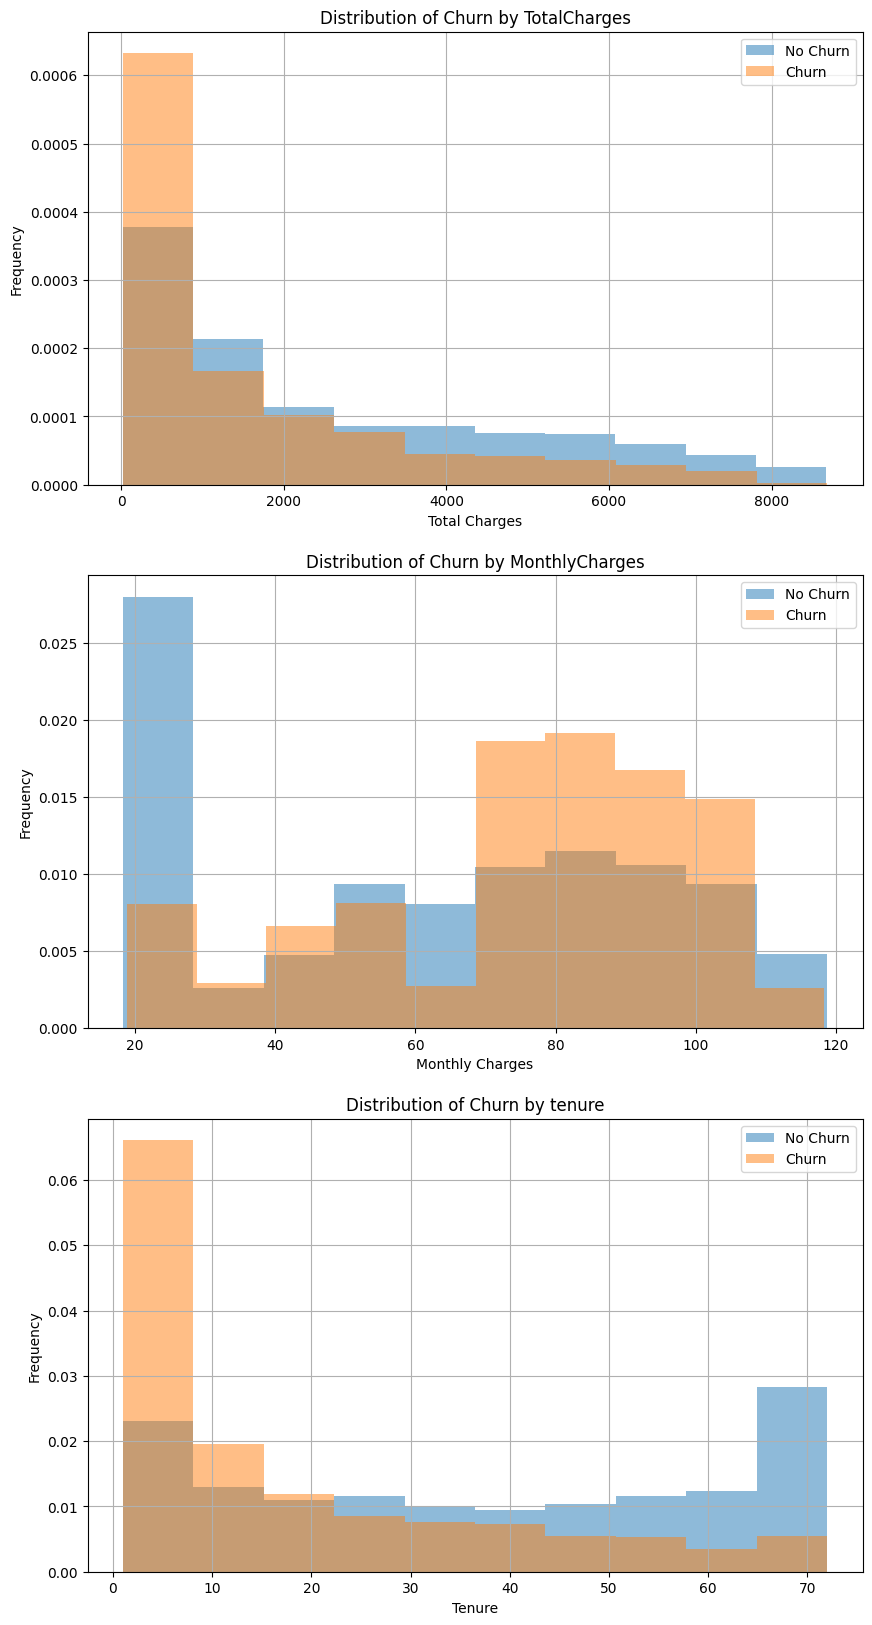

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20), sharex=False, sharey=False)

df.groupby('Churn')['TotalCharges'].hist(alpha=0.5,density=True, legend=True, ax=ax[0])
ax[0].set_xlabel('Total Charges')
ax[0].set_ylabel('Frequency')
ax[0].legend(['No Churn', 'Churn'])
ax[0].set_title('Distribution of Churn by TotalCharges')

df.groupby('Churn')['MonthlyCharges'].hist(alpha=0.5,density=True, legend=True, ax=ax[1])
ax[1].set_xlabel('Monthly Charges')
ax[1].set_ylabel('Frequency')
ax[1].legend(['No Churn', 'Churn'])
ax[1].set_title('Distribution of Churn by MonthlyCharges')

df.groupby('Churn')['tenure'].hist(alpha=0.5,density=True, legend=True, ax=ax[2])
ax[2].set_xlabel('Tenure')
ax[2].set_ylabel('Frequency')
ax[2].legend(['No Churn', 'Churn'])
ax[2].set_title('Distribution of Churn by tenure')

plt.show()



By evaluating the numerical Customer Account Information attributes, we can extract the following conclusions:

- The churn rate tends to be larger when monthly charges are high.
- New customers (low tenure) are more likely to churn.
- Clients with high total charges are less likely to leave the company.

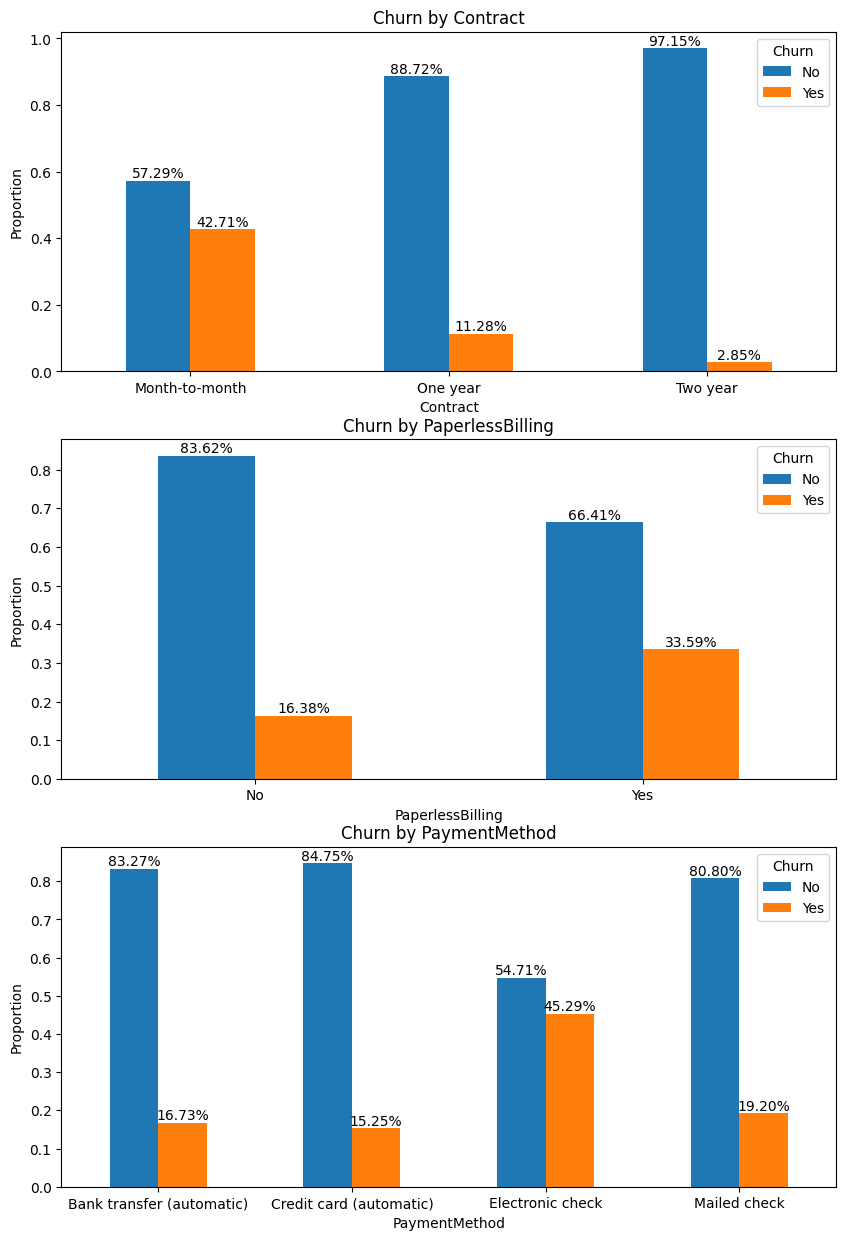

In [19]:
fig, ax = plt.subplots(3,1, figsize=(10,15))

# Loop over each subplot
for i, (col, subplot) in enumerate(zip(['Contract','PaperlessBilling','PaymentMethod'], ax.flatten())):

    # Create the crosstab for the current subplot
    ctr = pd.crosstab(index=df[col], columns=df['Churn'])
    
    # Normalize the data
    ctr_norm = ctr.div(ctr.sum(axis=1), axis=0)
    
    # Create the bar chart
    ctr_norm.plot.bar(ax=subplot, rot=0)
    
    # Add percentages for each segment of the bar chart
    for j, bar in enumerate(subplot.containers):
        total = ctr.iloc[j].sum()
        for rect in bar:
            percentage = f"{100*rect.get_height():.2f}%"
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height()
            subplot.text(x, y, percentage, ha='center', va='bottom', fontsize=10)
    
    # Add axis labels and title
    subplot.set_xlabel(col)
    subplot.set_ylabel('Proportion')
    subplot.set_title(f'Churn by {col}')

plt.show()


By evaluating the categorical Customer Account Information attributes, we can extract the following conclusions:

- Customers with month-to-month contracts have higher churn rates compared to clients with yearly contracts.
- Customers who opted for an electronic check as paying method are more likely to leave the company.
- Customers subscribed to paperless billing churn more than those who are not subscribed.

### Demographic Factors

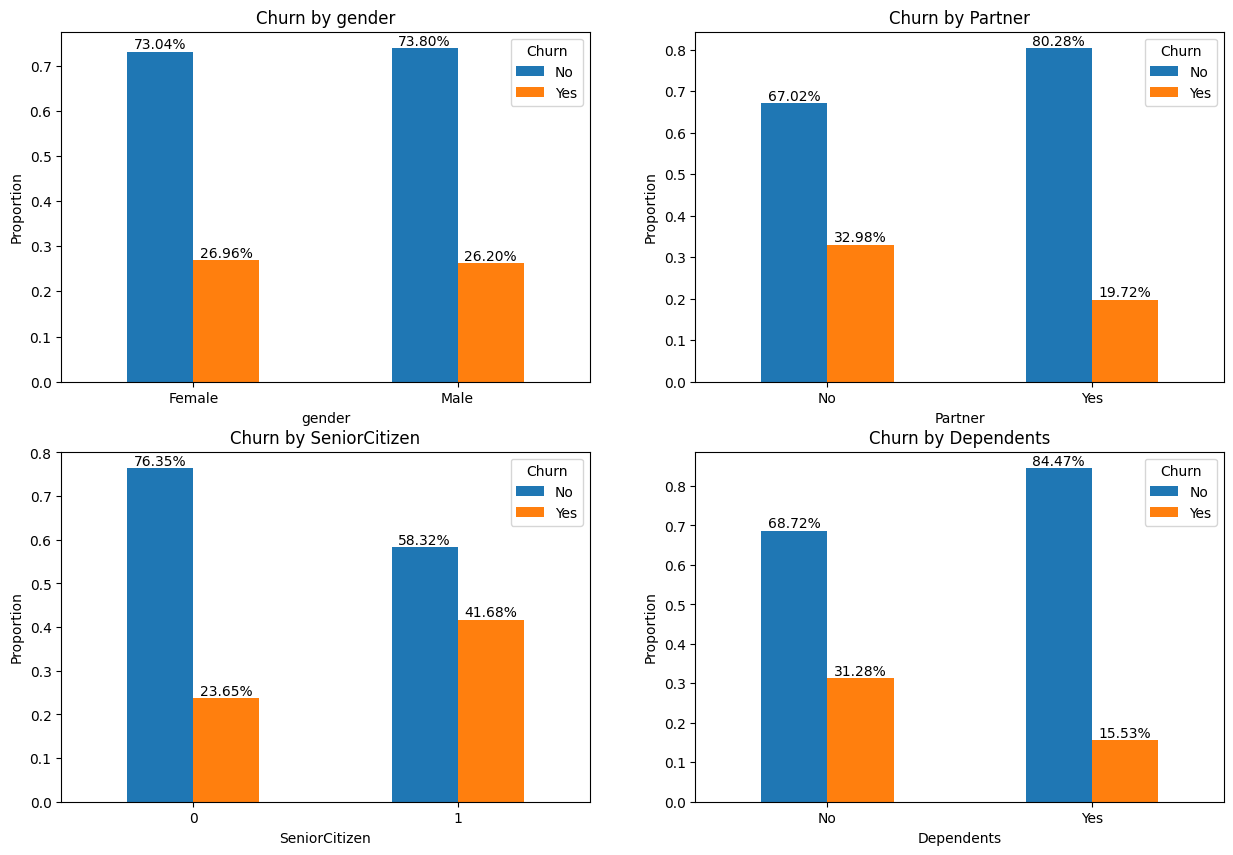

In [20]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

# Loop over each subplot
for i, (col, subplot) in enumerate(zip(['gender', 'Partner', 'SeniorCitizen', 'Dependents'], ax.flatten())):

    # Create the crosstab for the current subplot
    ctr = pd.crosstab(index=df[col], columns=df['Churn'])
    
    # Normalize the data
    ctr_norm = ctr.div(ctr.sum(axis=1), axis=0)
    
    # Create the stacked bar chart
    ctr_norm.plot.bar(ax=subplot, rot=0)
    
    # Add percentages for each segment of the bar chart
    for j, bar in enumerate(subplot.containers):
        total = ctr.iloc[j].sum()
        for rect in bar:
            percentage = f"{100*rect.get_height():.2f}%"
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height()
            subplot.text(x, y, percentage, ha='center', va='bottom', fontsize=10)
    
    # Add axis labels and title
    subplot.set_xlabel(col)
    subplot.set_ylabel('Proportion')
    subplot.set_title(f'Churn by {col}')

plt.show()

We can extract the following conclusions by analyzing demographic attributes:

- The churn rate of senior citizens is almost double that of young citizens.
- Gender does not seem to have significant predictive power.
- Customers with a partner churn less than customers with no partner
- Customers with Dependents Churn half the amount of customers without Dependents

## Feature Engineering 

This section prepares the data for model testing. 
We need to encode categorical features and normalise numerical features so that our models can run using the data.

### Label and One Hot Encoding 

In [21]:
labelencoder=LabelEncoder()

x= ['gender', 'Partner', 'Dependents','PaperlessBilling','PhoneService','Churn']

df[x] = df[x].apply(labelencoder.fit_transform)

In [22]:
col = ['MultipleLines','InternetService','OnlineSecurity','DeviceProtection','TechSupport',
       'StreamingTV','StreamingMovies','Contract','PaymentMethod','OnlineBackup']

df = pd.get_dummies(df,columns = col)

### Normalisation

MinMax Scaling is chosen for nomalisation. It is a common technique which scales the data from 0 to 1 by subtracting the minimum value of the feature and divides by the range of the feature. This helps to aviod numerical instability that could arise when the input features are on different scales and it makes the data easier to interpret as the values are between 0 and 1 which could help the model performance.

In [23]:
column_names_to_normalize = ['tenure', 'TotalCharges', 'MonthlyCharges']
scaler = MinMaxScaler()

df[column_names_to_normalize] = scaler.fit_transform(df[column_names_to_normalize])

In [24]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes
0,0,0,1,0,0.000000,0,1,0.115423,0.001275,0,...,True,False,False,False,False,True,False,False,False,True
1,1,0,0,0,0.464789,1,0,0.385075,0.215867,0,...,False,True,False,False,False,False,True,True,False,False
2,1,0,0,0,0.014085,1,1,0.354229,0.010310,1,...,True,False,False,False,False,False,True,False,False,True
3,1,0,0,0,0.619718,0,0,0.239303,0.210241,0,...,False,True,False,True,False,False,False,True,False,False
4,0,0,0,0,0.014085,1,1,0.521891,0.015330,1,...,True,False,False,False,False,True,False,True,False,False


## Feature Importance 

A view of feature importance ranked on the dataset using Mutual Information scores. Mutual information is a measure of the amount of information that one feature contains about the target in a dataset.This shows us the key relationships of the features to 'Churn'.

Text(0.5, 0, 'Mutual Information')

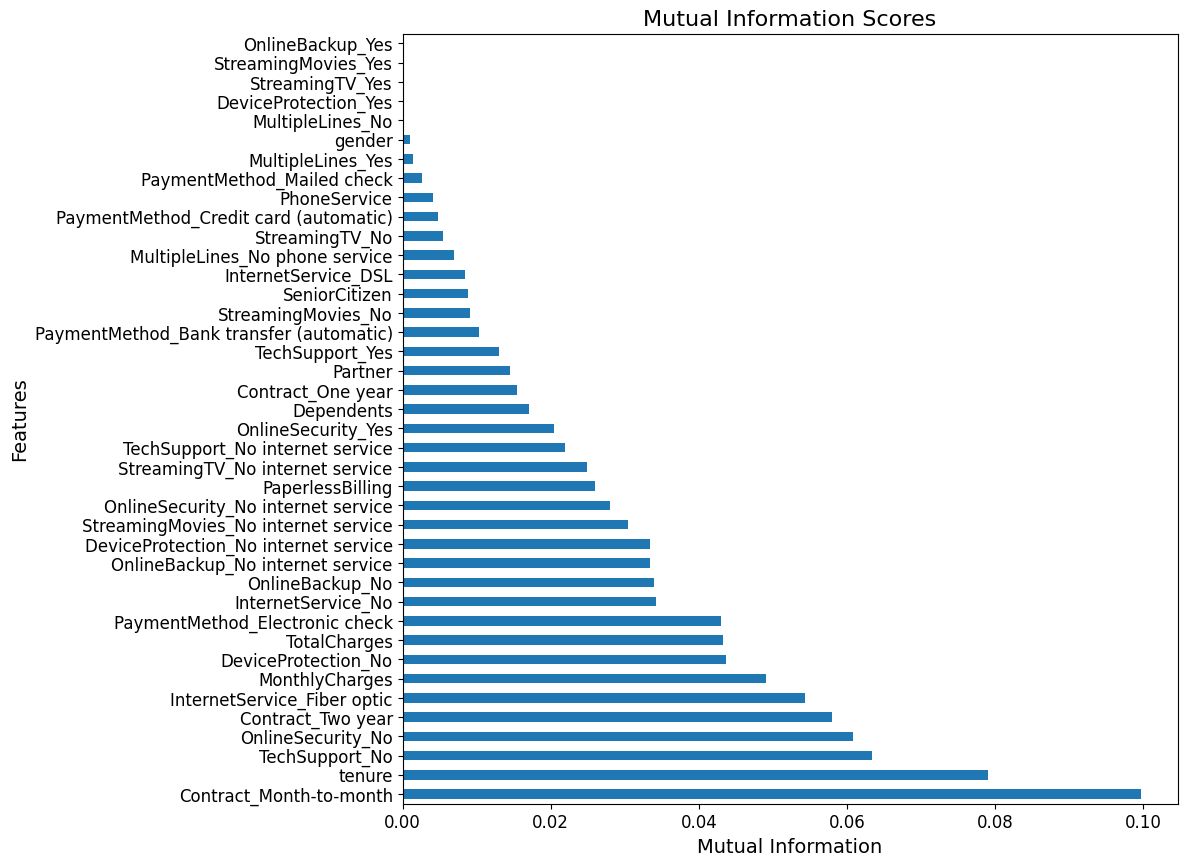

In [25]:
X= df.drop(columns='Churn')
y= df.loc[:,'Churn']

mutual_info = mutual_info_classif(X, y)

# create a pandas series with feature names as index
# and mutual information values as values
mutual_info_series = pd.Series(mutual_info, index=X.columns)

# sort the series in descending order to see the features
# with highest mutual information at the top
sorted_mutual_info = mutual_info_series.sort_values(ascending=False)

# plot the sorted mutual information values as a bar plot
ax = sorted_mutual_info.plot(kind='barh', figsize=(10,10), fontsize=12)
ax.set_title('Mutual Information Scores', fontsize=16)
ax.set_ylabel('Features', fontsize=14)
ax.set_xlabel('Mutual Information', fontsize=14)

As expected from the visual analysis, features such as gender and phone service have very little to no correlation to 'Churn' and features such as 'tenure' and 'Month-to-Month Contracts' have a high correlation to 'Churn'. 

In the next section I will use Machine Learinng algorithms to find the most important features against Churn.

## Data Training

This section explores Data Training. we use three models scored on multiple different metrics. The hyper-parameters are tuned then the best model we explored is used for feature importance ranking. The metrics I will be focused on will be ROC AUC, Recall and F1 score because these metrics will give me the best indication for predicting Churn which will help me find the key features in retaining customers.

Below are the models used in this study and an explanation of scoring metrics. The following models were chosen because they are all common models used, they are very good at dealing with mixture of categorical and continuous data and can handle non-linear relationships between variables.

Models:

- Logistic Regression 
        -  Linear algorithm is a linear algorithm that is well-suited to binary classification problems such as this. 

- Support Vector Machine 
        - Non-linear algorithm that is effective at handling datasets with many features.

- Random Forest Algorithm 
        - Ensemble learning method that combines multiple decision trees and effective at handling many features.


Scoring Metrics

- Accuracy measures the percentage of correctly classified instances out of all instances. 
        -  It indicates the percentage of correctly predicted churn and non-churn customers. However, if the churn and non-churn customers are imbalanced, then accuracy might not be the best metric to evaluate the model performance, as a high accuracy score could be achieved by simply predicting the majority class. 

- Precision measures the percentage of correctly classified positive instances out of all instances that are predicted as positive.
        - In this dataset precision would refer to the proportion of correctly identified churn cases among all the predicted churn cases

- Recall (also known as sensitivity or true positive rate) measures the percentage of correctly classified positive instances out of all actual positive instances.
        - Recall measures the model's ability to correctly identify all the customers who are likely to churn.

- ROC AUC (Receiver Operating Characteristic Area Under the Curve) score measures the model's ability to distinguish between positive and negative classes.
        - In terms of churn, a high ROC AUC score indicates that the classifier is able to accurately distinguish between churners and non churners
        
- F1 Score measures the performance taking into account both precision and recall.
        -In terms of churn, a high f1 score indicates that the model has correctly identified churned and non-churned customers.
    

- Classification_report 
        -a text report that includes precision, recall, f1-score, and support for each class

- Confusion_matrix 
        -a matrix that shows the count of true positives, false positives, false negatives, and true negatives. The diagonal of the matrix shows the true positives and true negatives, while the off-diagonal shows the false positives and false negatives


In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Define the classifiers
models = [   
          ('Logistic Regression', LogisticRegression(random_state=5)),  
          ('Support Vector Machine', SVC(random_state=5)),   
          ('Random Forest', RandomForestClassifier(random_state=5))
         ]


# Train and evaluate each classifier
print('-----------------------------------------')

for name, model in models:
    print('\033[1m' + '{}'.format(name) + '\033[0m\n')
    
    # Evaluate the model on the test set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    
     # Compute the evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    auc_score = roc_auc_score(y_test, y_test_pred)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_report = classification_report(y_test, y_test_pred)
    
    # Print the evaluation metrics
    print("Accuracy: {:.3f}".format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("F1 score: {:.3f}".format(f1))
    print("AUC: {:.3f}".format(auc_score))
    
    print('\nConfusion matrix:\n')
    print(conf_matrix)
    print('\nClassification Report:\n')
    print(class_report)
    
    print('----------------------------------------------------------')


-----------------------------------------
Logistic Regression

Accuracy: 0.795
Precision: 0.679
Recall: 0.559
F1 score: 0.613
AUC: 0.725

Confusion matrix:

[[891 108]
 [180 228]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       999
           1       0.68      0.56      0.61       408

    accuracy                           0.80      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.79      0.80      0.79      1407

----------------------------------------------------------
Support Vector Machine

Accuracy: 0.783
Precision: 0.667
Recall: 0.500
F1 score: 0.571
AUC: 0.699

Confusion matrix:

[[897 102]
 [204 204]]

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       999
           1       0.67      0.50      0.57       408

    accuracy                           0.78      1407
   macro avg       0.74  

The logistic regression model has an AUC of 0.725 and recall of 0.559, which are both higher than the AUC and recall values of the other two models. However, all three models have similar accuracy values, with the logistic regression model having the highest accuracy of 0.795, followed by the support vector machine model with an accuracy of 0.783 and the random forest model with an accuracy of 0.773.

In terms of precision, the logistic regression model has the highest value of 0.677, followed by the support vector machine model with a precision of 0.667 and the random forest model with a precision of 0.647. The f1 score values also follow a similar pattern, with the logistic regression model having the highest value of 0.612, followed by the support vector machine model with a value of 0.571 and the random forest model with a value of 0.551.

Overall, the logistic regression model is the best performing model. However, it is important to test hyper parameters so that we can improve performance further.

### Hyper Parameter Testing

This section explores hyper-parameter testing for the three models to see if we can improve performance.
We use StratifiedKFold cross-validation to split the dataset into k folds and train on k-1 folds. I chose StratifiedKfold because it is the useful when dealing with unbalanced datasets such as this. 
Gridsearch to give an extensive search of hyperparameters however only some hyper parameters are tested and the rest is left for future work.

#### Logistic Regression

In [27]:
# define the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

# define the parameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 250, 500, 1000]
}

# instantiate the logistic regression model
lr = LogisticRegression(random_state=5)

# instantiate the GridSearchCV object
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    refit='roc_auc',
    cv=skf,
    verbose=1,
    n_jobs=-1
)

# fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# print the best hyperparameters and the corresponding mean cross-validation score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Corresponding mean cross-validation score: {grid_search.best_score_:.3f}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best hyperparameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Corresponding mean cross-validation score: 0.844


In [28]:
#Best hyperparameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

#### Support Vector Machine 

In [29]:
# define the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

# define the parameter grid to search over
param_grid = {
    
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.1, 1],
}

# instantiate the SVM model
svm = SVC(random_state=5)

# instantiate the GridSearchCV object
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    refit='roc_auc',
    cv=skf,
    verbose=1,
    n_jobs=-1
)

# fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# print the best hyperparameters and the corresponding mean cross-validation score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Corresponding mean cross-validation score: {grid_search.best_score_:.3f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Corresponding mean cross-validation score: 0.836


In [30]:
#Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

#### Random Forest Classifer

In [31]:
# define the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

# define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# instantiate the Random Forest model
rf = RandomForestClassifier(random_state=5)

# instantiate the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    refit='roc_auc',
    cv=skf,
    verbose=1,
    n_jobs=-1
)

# fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# print the best hyperparameters and the corresponding mean cross-validation score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Corresponding mean cross-validation score: {grid_search.best_score_:.3f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}
Corresponding mean cross-validation score: 0.844


In [32]:
#Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}

### Model Testing with HyperParameters

Given the best hyperparameters tested, we test our models again to find the best model.

In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Define the classifiers
models = [
          ('Logistic Regression', LogisticRegression(random_state=5,C=100, max_iter=100, penalty= 'l2', solver= 'liblinear')),
          ('Support Vector Machine', SVC(random_state=5,C=0.1, gamma='scale', kernel = 'linear')),
          ('Random Forest', RandomForestClassifier(random_state=5,class_weight='balanced',max_depth = 10, max_features = 'log2', n_estimators = 500))

]

# Train and evaluate each classifier
print('-----------------------------------------')
for name, model in models:
    print('\033[1m' + '{}'.format(name) + '\033[0m\n')
    


    # Evaluate the model on the test set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    
     # Compute the evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    auc_score = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_report = classification_report(y_test, y_test_pred)
    
    # Print the evaluation metrics
    print("Accuracy: {:.3f}".format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("AUC: {:.3f}".format(auc_score))
    print("F1 score: {:.3f}".format(f1))
    
    
    print('\nConfusion matrix:\n')
    print(conf_matrix)
    print('\nClassification Report:\n')
    print(class_report)
    print('----------------------------------------------------------')


-----------------------------------------
Logistic Regression

Accuracy: 0.797
Precision: 0.682
Recall: 0.561
AUC: 0.727
F1 score: 0.616

Confusion matrix:

[[892 107]
 [179 229]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       999
           1       0.68      0.56      0.62       408

    accuracy                           0.80      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.79      0.80      0.79      1407

----------------------------------------------------------
Support Vector Machine

Accuracy: 0.788
Precision: 0.663
Recall: 0.549
AUC: 0.717
F1 score: 0.601

Confusion matrix:

[[885 114]
 [184 224]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       999
           1       0.66      0.55      0.60       408

    accuracy                           0.79      1407
   macro avg       0.75  

The Random Forest model outperformed the Logistic Regression and Support Vector Machine models in terms of AUC, recall and F1 Score. 

The Random Forest model had an AUC of 0.766, recall of 0.740 and F1 Score of 0.661, while the Logistic Regression and Support Vector Machine models had AUC values of 0.727 and 0.717, respectively,recall values of 0.561 and 0.549, respectively and F1 scores of 0.616 and 0.601, respectively. 

The confusion matrix for the random forest model indicates that: 

There are 999 (794+205=999) actual non-churn values (794 as non churn and 205 as churn) 
While, there are 408 (107+301=408) actual churn values (107 as non churn values and 301 as churn values)

Next, we move to feature importance with the Random Forest Model to find the key relationships to Churn.



### Feature Importance

This section explores the feaure importance calculated from the Random Forest Model.

                                    feature  importance
4                                    tenure    0.125777
8                              TotalCharges    0.117847
30                  Contract_Month-to-month    0.105308
7                            MonthlyCharges    0.083149
32                        Contract_Two year    0.059699
15                        OnlineSecurity_No    0.057075
21                           TechSupport_No    0.043797
13              InternetService_Fiber optic    0.040952
35           PaymentMethod_Electronic check    0.032906
37                          OnlineBackup_No    0.019880
31                        Contract_One year    0.018485
18                      DeviceProtection_No    0.018305
12                      InternetService_DSL    0.017637
6                          PaperlessBilling    0.017400
23                          TechSupport_Yes    0.016401
17                       OnlineSecurity_Yes    0.015367
0                                    gender    0

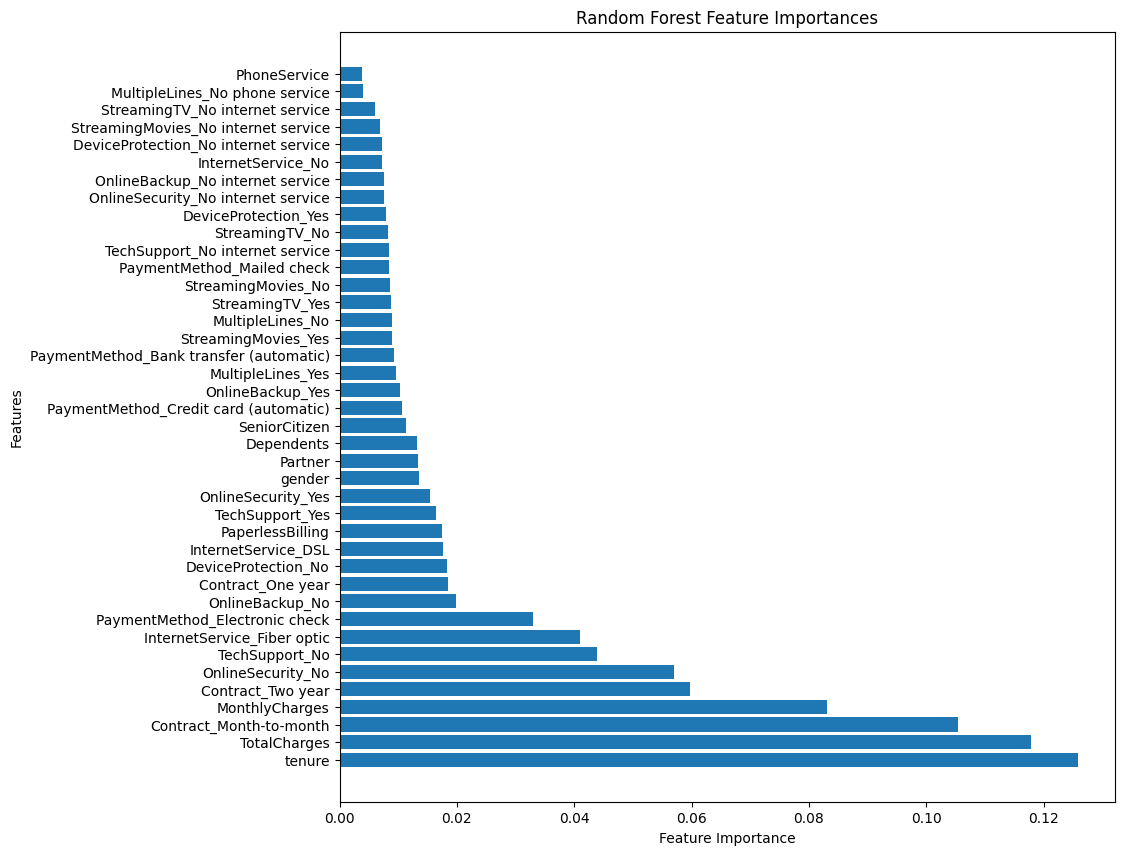

In [34]:
# Fit Random Forest model
model = RandomForestClassifier(random_state=5, class_weight='balanced', max_depth=10, max_features='log2', n_estimators=500)
model.fit(X_train, y_train)

# Get feature importance
feat_imp = pd.DataFrame({"feature": X.columns, "importance": model.feature_importances_})
feat_imp = feat_imp.sort_values("importance", ascending=False)

print(feat_imp)

# Create a bar plot of feature importances
plt.figure(figsize=(10, 10))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importances')
plt.show()


Based on the feature importances for the Random Forest model, we can see that the most important features for predicting churn are:

1. tenure
2. TotalCharges
3. Contract_Month-to-month
4. MonthlyCharges
5. Contract_Two year
6. OnlineSecurity_No
7. TechSupport_No
8. InternetService_Fiber optic
9. PaymentMethod_Electronic check

These features can help the business understand which factors have the biggest impact on churn and can be used to develop strategies to reduce churn. 

For example, the company may want to focus on reducing customer churn by offering promotions or incentives to customers who have a high risk of churning, such as those who have been with the company for a short time, have high monthly charges, or are on a month-to-month contract.

In [49]:
joblib.dump(model, './../models/model.joblib')

['./../models/model.joblib']